# Environment set up

In [10]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

# for speeding up sampling
import jax
import jax.numpy as jnp

# for sampling and plotting
import emcee
import corner

work_dir = './'


The $\Delta\nu$ scaling relation states that
\begin{equation}
\frac{\Delta\nu}{\Delta\nu_\odot} = f_{\Delta\nu} \left(\frac{M}{M_\odot}\right)^{1/2} \left(\frac{R}{R_\odot}\right) ^{-3/2}
\end{equation}
where $f_{\Delta\nu}$ is a correction factor that maps a star's density to its p-mode large separation $\Delta\nu$. This factor can be calculated from stellar models by comparing these two quantities. Previous works did not consider the surface effect on the model-calculated $\Delta\nu$; therefore those values for $f_{\Delta\nu}$ may be systematically larger than what they should be. In this work, we corrected the surface effect. 

The following code demonstrates how to calculate a star's corretion factor of the $\Delta\nu$ scaling relation, $f_{\Delta\nu}$, given some observational constraints.

# Sampler

## Step 1: download models
- Navigate "https://zenodo.org/record/7905521"
- Download "stats_models_for_fDnu_ANN_weights.npy" 

## Step 2: read in the statistical stellar models

In [11]:
# collect ANN weights
# weights = np.load('models/fDnu/fDnu_ANN_weights.npy', allow_pickle=True)[()] 
weights = np.load('models/stats_models_for_fDnu_ANN_weights.npy', allow_pickle=True)[()] 
kernels, biases = weights['kernels'], weights['biases']
kernels = [jnp.array(k) for k in kernels]
biases = [jnp.array(b) for b in biases]

# collect scaling parameters
xmin = jnp.array([[1.300214  , 0.22000916, 0.00156362, 0.70024   , 0.        ]])
xmax = jnp.array([[2.6999570e+00, 3.1999084e-01, 5.2185210e-02, 2.2999500e+00, 3.0000000e+02]])
ysig = jnp.array([[0.11590956, 0.43166455, 0.2986642 , 0.59469982, 0.42285968, 0.42092176]])
ymin = jnp.array([[ 3.47699917, -2.64096526, -0.21376869, -2.59942798,  0.22566342, 0.23851799]])

@jax.jit
def scale_x(x):
    return (x - xmin) / (xmax - xmin)

@jax.jit
def inv_scale_x(sx):
    return sx * (xmax - xmin) + xmin

@jax.jit
def scale_y(y):
    return (y - ymin) / ysig

@jax.jit
def inv_scale_y(sy):
    return sy * ysig + ymin

@jax.jit
def leaky_relu(x, alpha=0.2):
    x = jnp.where(x<0, alpha*x, x)
    return x

@jax.jit
def stellar_stats_model(xs):
    '''
    Get observables (Teff, surface_Z/X, radius, age, Dnu_freq, Dnu_freq_o)
    given input parameters (amlt, Yinit, Zinit, mass, EEP).
    The input parameters must be in the range defined by xmin and xmax, 
    otherwise nan will be returned.
    
    Input:
    xs: array-like[num_sample, 5]
    
    Output:
    ys: array-like[num_sample, 6]
    
    '''
    
    xs = jnp.atleast_2d(xs)
    
    # min-max scale for input parameters
    r = scale_x(xs)

    for ilayer in range(9):
        # multiply and sum
        r = jnp.einsum('ij, jk -> ik', r, kernels[ilayer]) + biases[ilayer]
        # apply activation function
        r = leaky_relu(r) 
    
    # reverse std normalisation and log10 transform
    ys = 10.0**inv_scale_y(r)
    
    # filter those fall out of the input parameter range
    idx = jnp.transpose(jnp.array([jnp.sum((xmin < xs) & (xs < xmax), axis=1) != 5 ]*6))
    ys = jnp.where(idx, jnp.nan, ys)
    
    return ys

## step 3: define an optimization function to be used by emcee

In [12]:
cols_inputs = ['amlt', 'Yinit', 'Zinit', 'mass', 'eep']
cols_outputs = ['Teff', 'surface_Z/X', 'radius', 'age', 'Dnu_freq', 'Dnu_freq_o']

Dnu_sun_model = 135.0959
density_sun_model = 1.00570

@jax.jit
def log_prob(xs, constraints):
    ys = stellar_stats_model(xs)
    
    # get physical properties of the star from the model predictions
    amlt, Yinit, Zinit, mass, eep = xs[:,0], xs[:,1], xs[:,2], xs[:,3], xs[:,4]
    
    # calculate the predicted observables for the star
    Teff, surface_Z_X, radius, age, Dnu_freq, Dnu_freq_o = ys[:,0], ys[:,1], ys[:,2], ys[:,3], ys[:,4], ys[:,5]
    
    # calculate some derived properties
    MH = jnp.log10(surface_Z_X) - jnp.log10(0.0181)
    lum = radius**2.0 * (Teff/5777)**4.0
    logg = jnp.log10(mass * radius**-2.0 * 274)
    density = mass * radius**-3.0 
    fDnu = (Dnu_freq/Dnu_sun_model) * (density/density_sun_model)**-0.5
    numax = mass * radius**-2.0 * (Teff/5777)**-0.5 * 3090.
    
    # calculate the log likelihood of the observables given the observational constraints
    log_like_Teff = -0. 
    log_like_MH = -0. 
    log_like_radius = -0. 
    log_like_age = -0. 
    log_like_Dnu = -0. 
    log_like_numax = -0. 
    log_like_lum = -0. 
    log_like_logg = -0. 
    log_like_mass = -0. 
    log_like_density = -0.
    
    if 'Teff' in constraints:
        log_like_Teff = jax.scipy.stats.norm.logpdf(Teff, constraints['Teff'], constraints['e_Teff'])
    if 'MH' in constraints:
        log_like_MH = jax.scipy.stats.norm.logpdf(MH, constraints['MH'], constraints['e_MH'])
    if 'radius' in constraints:
        log_like_radius = jax.scipy.stats.norm.logpdf(radius, constraints['radius'], constraints['e_radius'])
    if 'age' in constraints:
        log_like_age = jax.scipy.stats.norm.logpdf(age, constraints['age'], constraints['e_age'])
    if 'Dnu' in constraints:
        log_like_Dnu = jax.scipy.stats.norm.logpdf(Dnu_freq, constraints['Dnu'], constraints['e_Dnu'])
    if 'numax' in constraints:
        log_like_numax = jax.scipy.stats.norm.logpdf(numax, constraints['numax'], constraints['e_numax'])
    if 'lum' in constraints:
        log_like_lum =jax.scipy.stats.norm.logpdf(lum, constraints['lum'], constraints['e_lum'])
    if 'logg' in constraints:
        log_like_logg = jax.scipy.stats.norm.logpdf(logg, constraints['logg'], constraints['e_logg'])
    if 'mass' in constraints:
        log_like_mass = jax.scipy.stats.norm.logpdf(mass,constraints['mass'], constraints['e_mass'])
    if 'density' in constraints:
        log_like_density = jax.scipy.stats.norm.logpdf(density,constraints['density'], constraints['e_density'])
        
    # Calculate the total log likelihood
    total_log_like = log_like_Teff + log_like_MH + log_like_radius + log_like_age + \
                     log_like_Dnu + log_like_numax + log_like_lum + log_like_logg + \
                     log_like_mass + log_like_density
    
    total_log_like = jnp.where(jnp.isfinite(total_log_like), total_log_like, -jnp.inf)
    
    return total_log_like

## step 4: set up the observational constraints (observables) for a star

supported constraints include Teff, MH, radius, age, Dnu, numax, lum, logg, mass, density

In [13]:
# the Sun
constraints = {
    'Teff': 5777,
    'e_Teff': 50,
    'MH': 0.0, 
    'e_MH': 0.06,
    'Dnu': 135.1,
    'e_Dnu': 1.0,
    'numax': 3090.,
    'e_numax': 100.,
    'lum': 1.0, 
    'e_lum': 0.1,
}

# # Another example:
# # KIC 10000547
# constraints = {
#     'Teff': 4969,
#     'e_Teff': 50,
#     'MH': -0.26, 
#     'e_MH': 0.06,
#     'Dnu': 13.212,
#     'e_Dnu': 0.022,
#     'numax': 160.75,
#     'e_numax': 0.65,
#     'lum': 12.68, 
#     'e_lum': 0.51,
# }

## step 5: run optimizer

In [14]:
ndim, nwalkers = 5, 100
p0 = inv_scale_x(np.random.rand(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[constraints], vectorize=True)
sampler.run_mcmc(p0, 5000, progress=True);

100%|██████████| 5000/5000 [01:14<00:00, 66.87it/s] 


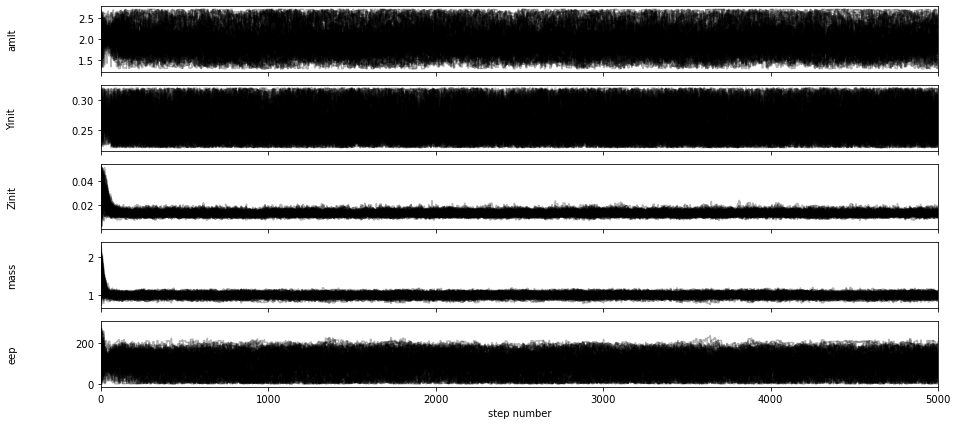

In [15]:
# examine the traces
fig, axes = plt.subplots(5, figsize=(15, 7), sharex=True)
samples = sampler.get_chain()
labels = cols_inputs
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

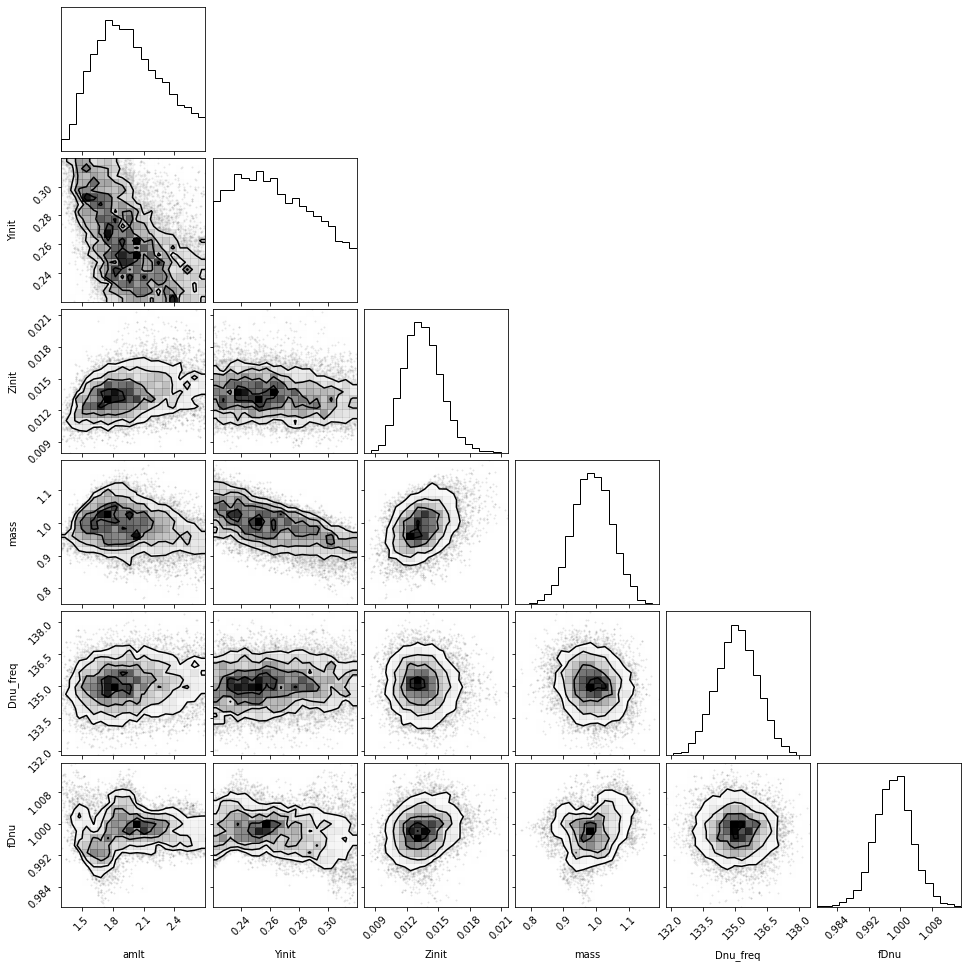

In [21]:
# get samples from emcee
xs = sampler.get_chain(discard=2500, flat=True)
ys = stellar_stats_model(xs)

# put everything into a pandas dataframe
samples = jnp.concatenate([xs, ys], axis=1).__array__()
samples = pd.DataFrame(samples, columns=cols_inputs+cols_outputs)

# add some new columns
samples['numax'] = samples['mass'] * samples['radius'] **-2.0 * (samples['Teff']/5777)**-0.5 * 3090.
samples['density'] = samples['mass'] * samples['radius']**-3.
samples['fDnu'] = (samples['Dnu_freq']/Dnu_sun_model) * (samples['density']/density_sun_model)**-0.5

# trim data points
samples = samples.sample(10000)#.query('age<12 & numax<165')

# make a corner plot
cols = ['amlt', 'Yinit', 'Zinit', 'mass', 'Dnu_freq', 'fDnu']
fig = corner.corner(samples[cols]);

In [22]:
# get quantities we care and their uncertainties
stats = samples.describe(percentiles=[0.16, 0.50, 0.84])

# this might be frowned upon, but is very simple
stats.loc['err',:] = (stats.loc['84%',:]-stats.loc['16%',:])/2. 

stats.loc['med',:] = stats.loc['50%',:]

stats = stats.loc[['med', 'err'],:]
stats

,amlt,Yinit,Zinit,mass,eep,Teff,surface_Z/X,radius,age,Dnu_freq,Dnu_freq_o,numax,density,fDnu
med,1.929786,0.261812,0.013407,0.987590,101.939102,5778.728027,0.01858,0.992398,4.154860,135.084442,135.787621,3097.831177,1.009063,0.998358
err,0.345114,0.030507,0.001778,0.059028,58.112430,46.481563,0.00252,0.022080,3.138173,0.963579,1.011163,62.622871,0.017313,0.004632


# Caveats 

Here I show the accuracy of this statistical model by plotting the difference between predictions and actual labels.

The fDnu generated by this model has intrinsic scatter of 0.5%, which needs to be aware of.


In [128]:
# read in model data
df = pd.read_parquet(work_dir+'models/fDnu/fDnu_grid_eep.parquet')

cols_inputs = ['amlt', 'Yinit', 'Zinit', 'mass', 'eep']
cols_outputs = ['Teff', 'surface_Z/X', 'radius', 'age', 'Dnu_freq', 'Dnu_freq_o']

a = np.arange(0, len(df), 1)
np.random.seed(0)
idx = np.random.choice(a, size=10000, replace=False)

xs = df.loc[idx, cols_inputs].to_numpy()
ys = df.loc[idx, cols_outputs].to_numpy()

predictions = np.asarray(stellar_stats_model(xs))
actuals = np.asarray(ys)

fDnu_actuals = (actuals[:,4]/1.) * (xs[:,3] * actuals[:,2]**-3.0 / 1.)**-0.5
fDnu_predictions = (predictions[:,4]/1.) * (xs[:,3] * predictions[:,2]**-3.0 / 1.)**-0.5
actuals = np.hstack([actuals, fDnu_actuals.reshape(-1,1)])
predictions = np.hstack([predictions, fDnu_predictions.reshape(-1,1)])

idx = (~np.isfinite(predictions)).sum(axis=1) == 0
actuals, predictions = actuals[idx,:], predictions[idx,:]

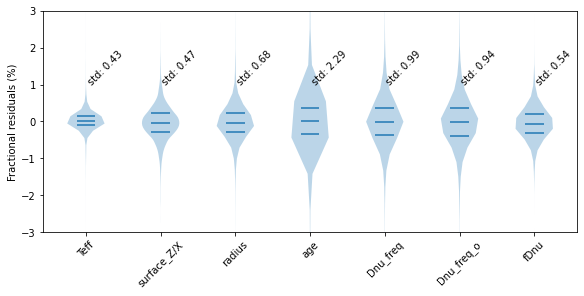

In [146]:
fig, axes = plt.subplots(figsize=[8, 4], nrows=1, ncols=1, squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

Nvar = 7

axes[0].violinplot((predictions/actuals-1)*100, quantiles=[[0.25, 0.75]]*Nvar, showextrema=False, showmedians=True)

axes[0].set_ylim(-3, 3)
axes[0].set_xticks(range(1,1+Nvar), cols_outputs + ['fDnu'], rotation=45)
axes[0].set_ylabel('Fractional residuals (%)')

for ivar in range(Nvar):
    axes[0].text(ivar+1, 1, 'std: {:.2f}'.format(np.std((predictions[:,ivar]/actuals[:,ivar]-1)*100)), rotation=45 )